In [28]:
import numpy as np
from utils import utils
from utils import dataset as ds
import torch
from torchvision import datasets, transforms
from modules import csvae_modules as mod_csvae
from modules import csgmm_modules as mod_csgmm
from modules import baselines as base
import time
import skimage.metrics as ski
import matplotlib.pyplot as plt
import random

Set up the global parameters

In [29]:
lr = 2e-5 # learning rate
miter = 1024 # maximal number of iterations
ddim = 784 # dimension of the data samples (N in our work)
sdim = 1443 # dimension of the sparse representation of the data samples (S in our work)
ydim = 200 # dimension of the sample observations (M in our work)
n_train = 5000 # number of training samples (N_t in our work)
n_val = 2000 # number of validation samples
n_test = 5000 # number of test samples
snr_db = 40 # signal-to-noise ratio in dB

# for the CSVAE
n_enc = 2 # number of encoder layers
n_dec = 2 # number of decoder layers
width = 256 # maximal width of the encoder and decoder layers
ldim = 16 # latent dimension of the CSVAE
bs = 64 # batchsize
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # device

# for the CSGMM
K = 32 # number of components

Load the MNIST dataset

In [30]:
transform = transforms.Compose([transforms.ToTensor()]) # transform applied to all data samples
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # load MNIST training set
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # load MNIST test set
num_train_images = len(mnist_train) # determine length of training smaples
num_test_images = len(mnist_test) # determine length of test samples
X_train = torch.zeros(num_train_images, ddim)
X_test = torch.zeros(num_test_images, ddim)
for i, (image, _) in enumerate(mnist_train):
    X_train[i] = torch.squeeze(image).reshape(-1) # reshape all images to a vector
for i, (image, _) in enumerate(mnist_test):
    X_test[i] = torch.squeeze(image).reshape(-1) # reshape all images to a vector
X_train = X_train.to(device)
X_test = X_test.to(device)
X_gt_train, X_gt_val = X_train[:n_train, :], X_train[n_train:n_train + n_val, :] # split into training and validation samples
X_gt_test = X_test[:n_test, :]

Generate an observation matrix and prepare the datasets and dataloaders for CSVAE and CSGMM

In [31]:
A = 1/torch.sqrt(torch.tensor(ydim).to(device)) * torch.randn(ydim,ddim).to(device) # draw Gaussian random observation matrix
X_obs_train = torch.einsum('ij,kj->ki', A, X_gt_train) # determine the training set of compressed observations (here noise is not included)
X_obs_val = torch.einsum('ij,kj->ki', A, X_gt_val) # determine the validation set of compressed observations (here noise is not included)
X_obs_test = torch.einsum('ij,kj->ki', A, X_gt_test) # determine the test set of compressed observations (here noise is not included)
DS_train_obs, DS_val_obs, DS_test_obs, DL_train_obs, DL_val_obs, DL_test_obs = ds.default_ds_dl_split(X_obs_train, X_obs_val, X_obs_test, bs)

A_np = A.to('cpu').numpy()
X_obs_train_np = X_obs_train.to('cpu').numpy()
X_obs_val_np = X_obs_val.to('cpu').numpy()
X_obs_test_np = X_obs_test.to('cpu').numpy()

Determine the dictionary and the SNR (only important to determine a small value for $\sigma^2$ used in (7) in our paper (see discussion in Appendix K). In this example the training, validation and test samples are not corrupted by noise, but only compressed by the observation matrix)

In [32]:
D = utils.generate_WaveletDict2D(int(np.sqrt(ddim)), d='db4') # create the set of 2D dictionary elements
D = np.reshape(D, (D.shape[0], -1)).T # compute the dictionary matrix
snr = 10 ** (snr_db / 10) # compute the snr
noise_var = torch.mean(torch.sum(X_obs_train ** 2, axis=1), axis=0) / (snr * ydim) # compute the correspoding noise variance

noise_var_np = noise_var.to('cpu').numpy()

Set up the CSVAE and CSGMM

In [33]:
CSVAE = mod_csvae.CSVAE(ydim, sdim, ldim, A, D, n_enc, n_dec, width, device, fix_zeta=noise_var).to(device)
CSGMM = mod_csgmm.CSGMM(K, ydim, sdim, ddim, A_np, D, fix_zeta=noise_var_np)

Train the CSVAE (you can skip this part if you only want to test the CSGMM) - We highly recommend using a GPU for training the CSVAE

In [34]:
r_tr, kl1_tr, kl2_tr, rec_tr, r_val, kl1_val, kl2_val, rec_val = CSVAE.fit(lr, DL_train_obs, DL_val_obs, miter, device, n_train, n_val)

Train the CSGMM (you can skip this part if you only want to test the CSVAE)

In [35]:
logl_track = CSGMM.fit(X_obs_train_np, miter)

Plot reconstructed MNIST images from CSVAE, CSGMM, and the baselines SBL and LASSO

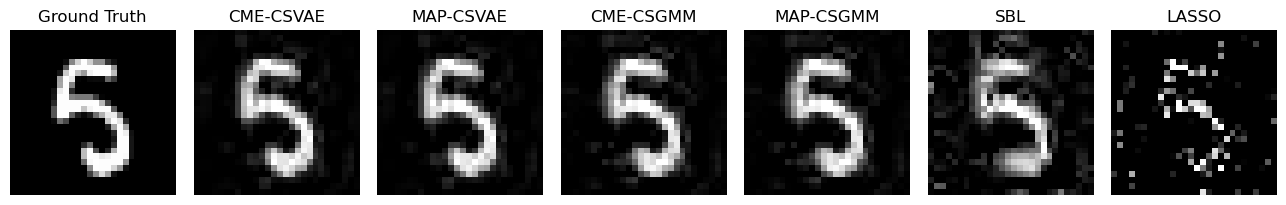

nMSE results:
CME-CSVAE: 0.0047, MAP-CSVAE: 0.0048, CME-CSGMM: 0.0078, MAP-CSGMM: 0.0078, SBL: 0.0227, LASSO: 0.0619
SSIM results:
CME-CSVAE: 0.7570, MAP-CSVAE: 0.7545, CME-CSGMM: 0.7029, MAP-CSGMM: 0.7029, SBL: 0.5636, LASSO: 0.3304


In [37]:
dim1d = int(np.sqrt(ddim))

# generate a random test ground truth sample
rand_idx = random.randint(0, n_test)
sample = X_gt_test[rand_idx, :].to('cpu').numpy()
sample_2d = sample.reshape((dim1d, dim1d))

# plot the reconstructed test ground truth sample by the CSVAE (using the MAP and CME-based estimators in Appendix G, Eq. (43),(42))
# you can comment out this part if you have not trained the CSVAE
X_test_de = X_obs_test[rand_idx, :][None, :].float().to(device)

start_csvae_map = time.time()
sMAP_csvae = torch.squeeze(CSVAE.cme(X_test_de))
sMAP_csvae = sMAP_csvae.detach().to('cpu').numpy()
xMAP_csvae = D @ sMAP_csvae
xclipMAP_csvae = np.copy(xMAP_csvae)
xclipMAP_csvae[xclipMAP_csvae > 1] = 1
xclipMAP_csvae[xclipMAP_csvae < 0] = 0
xclipMAP_csvae_2d = xclipMAP_csvae.reshape((dim1d,dim1d))

sCME_csvae = torch.squeeze(CSVAE.cme(X_test_de,mode='montecarlo',n_samples=16))
sCME_csvae = sCME_csvae.detach().to('cpu').numpy()
xCME_csvae = D @ sCME_csvae
xclipCME_csvae = np.copy(xCME_csvae)
xclipCME_csvae[xclipCME_csvae > 1] = 1
xclipCME_csvae[xclipCME_csvae < 0] = 0
xclipCME_csvae_2d = xclipCME_csvae.reshape((dim1d,dim1d))

# plot the reconstructed test ground truth sample by the CSGMM (using the MAP and CME-based estimators in Appendix G, Eq. (45),(44))
# you can comment out this part if you have not trained the CSGMM
X_test_np = X_obs_test_np[rand_idx, :]

sMAP_csgmm = np.squeeze(CSGMM.cme(X_test_np,mode='map'))
xMAP_csgmm = D @ sMAP_csgmm
xclipMAP_csgmm  = np.copy(xMAP_csgmm)
xclipMAP_csgmm [xclipMAP_csgmm  > 1] = 1
xclipMAP_csgmm [xclipMAP_csgmm  < 0] = 0
xclipMAP_csgmm_2d  = xclipMAP_csgmm.reshape((dim1d,dim1d))

sCME_csgmm  = np.squeeze(CSGMM.cme(X_test_np,mode='cme'))
xCME_csgmm  = D @ sCME_csgmm
xclipCME_csgmm  = np.copy(xCME_csgmm)
xclipCME_csgmm [xclipCME_csgmm  > 1] = 1
xclipCME_csgmm [xclipCME_csgmm  < 0] = 0
xclipCME_csgmm_2d  = xclipCME_csgmm.reshape((dim1d,dim1d))

# sbl baseline
sSBL = base.apply_sbl_torch(torch.squeeze(X_test_de), A@torch.tensor(D).float().to(device), miter,zeta_in = noise_var,device = device)
xSBL = D @ sSBL
xSBLclip = np.copy(xSBL)
xSBLclip[xSBLclip > 1] = 1
xSBLclip[xSBLclip < 0] = 0
xSBLclip_2d  = xSBLclip.reshape((dim1d,dim1d))

# lasso baseline in the MNIST image domain (i.e., D = identity) and shrinkage parameter 0.1
xLASSO = base.apply_lasso_sklearn(X_test_np,A_np,np.eye(ddim),0.1)
xLASSO_2d  = xLASSO.reshape((dim1d,dim1d))

imgs = [sample_2d,xclipCME_csvae_2d,xclipMAP_csvae_2d,xclipCME_csgmm_2d,xclipMAP_csgmm_2d,xSBLclip_2d,xLASSO_2d]
titles = ['Ground Truth','CME-CSVAE','MAP-CSVAE','CME-CSGMM','MAP-CSGMM','SBL','LASSO']

fig, axes = plt.subplots(1, 7, figsize=(13, 2))

for (ax_i,ax) in enumerate(axes):
    ax.imshow(imgs[ax_i],cmap='gray')
    ax.set_title(titles[ax_i])
    ax.axis('off')

plt.tight_layout()
plt.show()

nMSE_csvae_map = (np.linalg.norm(sample - xclipMAP_csvae) ** 2) / ddim
nMSE_csvae_cme = (np.linalg.norm(sample - xclipCME_csvae) ** 2) / ddim
nMSE_csgmm_map = (np.linalg.norm(sample - xclipMAP_csgmm) ** 2) / ddim
nMSE_csgmm_cme = (np.linalg.norm(sample - xclipCME_csgmm) ** 2) / ddim
nMSE_sbl = (np.linalg.norm(sample - xSBLclip) ** 2) / ddim
nMSE_lasso = (np.linalg.norm(sample - xLASSO) ** 2) / ddim

ssim_csvae_map = ski.structural_similarity(xclipMAP_csvae_2d, sample_2d, data_range=1)
ssim_csvae_cme = ski.structural_similarity(xclipCME_csvae_2d, sample_2d, data_range=1)
ssim_csgmm_map = ski.structural_similarity(xclipMAP_csgmm_2d, sample_2d, data_range=1)
ssim_csgmm_cme = ski.structural_similarity(xclipCME_csgmm_2d, sample_2d, data_range=1)
ssim_sbl = ski.structural_similarity(xSBLclip_2d, sample_2d, data_range=1)
ssim_lasso = ski.structural_similarity(xLASSO_2d, sample_2d, data_range=1)

print('nMSE results:')
print(f'CME-CSVAE: {nMSE_csvae_cme:.4f}, MAP-CSVAE: {nMSE_csvae_map:.4f}, CME-CSGMM: {nMSE_csgmm_cme:.4f}, MAP-CSGMM: {nMSE_csgmm_map:.4f}, SBL: {nMSE_sbl:.4f}, LASSO: {nMSE_lasso:.4f}')
print('SSIM results:')
print(f'CME-CSVAE: {ssim_csvae_cme:.4f}, MAP-CSVAE: {ssim_csvae_map:.4f}, CME-CSGMM: {ssim_csgmm_cme:.4f}, MAP-CSGMM: {ssim_csgmm_map:.4f}, SBL: {ssim_sbl:.4f}, LASSO: {ssim_lasso:.4f}')